In [1]:
using Pkg
Pkg.activate("..")
Pkg.instantiate()
Pkg.update()
Pkg.add("Plots")

  Activating environment at `~/CropModeling/Gattuce/Project.toml`
Precompiling project...
  ✓ JLLWrappers
  ✓ Xorg_xtrans_jll
  ✓ Xorg_libpthread_stubs_jll
  ✓ Xorg_libXau_jll
  ✓ JSON
  ✓ Pixman_jll
  ✓ Libmount_jll
  ✓ Xorg_libXdmcp_jll
  ✓ x265_jll
  ✓ Libuuid_jll
  ✓ Zstd_jll
  ✓ Libiconv_jll
  ✓ Libgpg_error_jll
  ✓ Ghostscript_jll
  ✓ Bzip2_jll
  ✓ libpng_jll
  ✓ PCRE_jll
  ✓ Wayland_protocols_jll
  ✓ FFTW_jll
  ✓ Expat_jll
  ✓ libfdk_aac_jll
  ✓ Libffi_jll
  ✓ EarCut_jll
  ✓ LAME_jll
  ✓ x264_jll
  ✓ OpenSSL_jll
  ✓ Ogg_jll
  ✓ Rmath_jll
  ✓ JpegTurbo_jll
  ✓ FriBidi_jll
  ✓ IntelOpenMP_jll
  ✓ Opus_jll
  ✓ OpenSpecFun_jll
  ✓ AssetRegistry
  ✓ Conda
  ✓ LERC_jll
  ✓ Graphite2_jll
  ✓ LZO_jll
  ✓ XML2_jll
  ✓ Libgcrypt_jll
  ✓ Rmath
  ✓ FreeType2_jll
  ✓ MKL_jll
  ✓ libvorbis_jll
  ✓ Libtiff_jll
  ✓ Wayland_jll
  ✓ XSLT_jll
  ✓ Fontconfig_jll
  ✓ Gettext_jll
  ✓ ImageMagick_jll
  ✓ Xorg_libxcb_jll
  ✓ Glib_jll
  ✓ Compose
  ✓ Xorg_libX11_jll
  ✓ Xorg_xcb_util_jll
  ✓ WebIO
  ✓ X

In [59]:
using Cropbox
using Test
using Plots
using TimeZones
using DataFramesMeta
using CSV
Cropbox.Interact.WebIO.setup(:ijulia)

WebIO._IJuliaInit()

In [173]:
include("../src/Garlic.jl")

import Dates

┌ Warning: duplicate variable
│   system = Mass
│   name = living_total_mass
│   alias = nothing => nothing
│   state = :Track => :Track
└ @ Cropbox /home/cariso27001/.julia/packages/Cropbox/2CDya/src/macro.jl:589


In [183]:
Lettuce = @config (
# # CV PHYL ILN GLN LL LER SG SD LTAR LTARa LIR Topt Tceil critPPD
# KM1 134 4 10 65.0 4.70 1.84 122 0 0.4421 0.1003 22.28 34.23 12
    :Phenology => (
        emergence_optimal_temperature = 15.0,
        emergence_ceiling_temperature = 28.0,
        # optimal_temperature = 22.28, # Topt
        optimal_temperature = 15, # Topt
        # ceiling_temperature = 34.23, # Tceil
        ceiling_temperature = 28, # Tceil
        critical_photoperiod = 24, # critPPD
        # critical_photoperiod = 12, # critPPD
        # initial_leaves_at_harvest = 5, # ILN
        # maximum_leaf_initiation_rate = 0.8, # LIR
        maximum_leaf_initiation_rate = 0.943214,
        # maximum_emergence_rate = 0.2,
        maximum_emergence_rate = 0.02,
        # maximum_leaf_initiation_rate = 0.1003, # LIR
        # storage_days = 100, # SD
        # storage_temperature = 5,
        # maximum_phyllochron_asymptote = 0.4421, # LTARa
        maximum_phyllochron_asymptote = 0.802838,
        # leaves_generic = 10, # GLN
        leaves_generic = 30, # GLN
        # storage_days = 122, # SD
        planting_date = ZonedDateTime(2021, 10, 12, tz"Asia/Taipei"), # Y1 sow
        emergence_date = ZonedDateTime(2021, 10, 24, tz"Asia/Taipei"), # Y1 emg
        # scape_removal_date = nothing, # Y2 SR
    ),
    :Leaf => (
        maximum_elongation_rate = 4.70, # LER
        # minimum_length_of_longest_leaf = 25.0, # LL
        minimum_length_of_longest_leaf = 15.0, # LL
        # stay_green = 1.84, # SG
        stay_green = 30,
        length_to_width_ratio = 0.8,
    ),
    :Carbon => (
# # Rm Yg
# 0.012 0.8
        # maintenance_respiration_coefficient = 0.012, # Rm
        maintenance_respiration_coefficient = 0.030, # Rm
        # synthesis_efficiency = 0.8, # Yg
        synthesis_efficiency = 0.7, # Yg
        partitioning_table = [
        # # root leaf sheath scape bulb
        #   0.00 0.00   0.00  0.00 0.00 ; # seed garlic before germination
        #   0.35 0.30   0.25  0.00 0.10 ; # vegetative stage between germination and scape initiation
        #   0.15 0.15   0.10  0.25 0.35 ; # period between scape initiation and scape appearance
        #   0.05 0.10   0.00  0.35 0.50 ; # period after scape appearance before removal (scape stays intact)
        #   0.05 0.00   0.00  0.00 0.95 ; # period after scape removal (scape appeared and subsequently removed)
        #   0.00 0.00   0.00  0.00 0.00 ; # dead
        # ],
        # root leaf stem
          0.00 0.00 0.00 ; # seed garlic before germination
          0.15 0.60 0.25 ; # vegetative stage
          0.00 0.00 0.00 ; # dead
        ],
    ),
    :Meta => (cultivar = :Cucumber,
        year = 2021,),
    :Weather => (
        CO2 = 390, # CO2
        store = Garlic.loadwea("$(@__DIR__)/../data/winter2021.wea", tz"Asia/Taipei"),
    ),
    :Plant => (initial_planting_density = 55,),
    :Calendar => (
        init = ZonedDateTime(2021, 10, 12, 18, tz"Asia/Taipei"), # Y1 bgn
        last = ZonedDateTime(2021, 12, 19, tz"Asia/Taipei"), #Y2 end
    ),
)

Config for 7 systems:
  Phenology
    emergence_optimal_temperature = 15.0
    emergence_ceiling_temperature = 28.0
    optimal_temperature           = 15
    ceiling_temperature           = 28
    critical_photoperiod          = 24
    maximum_leaf_initiation_rate  = 0.943214
    maximum_emergence_rate        = 0.02
    maximum_phyllochron_asymptote = 0.802838
    leaves_generic                = 30
    planting_date                 = ZonedDateTime(2021, 10, 12, tz"Asia/Taipei")
    emergence_date                = ZonedDateTime(2021, 10, 24, tz"Asia/Taipei")
  Leaf
    maximum_elongation_rate        = 4.7
    minimum_length_of_longest_leaf = 15.0
    stay_green                     = 30
    length_to_width_ratio          = 0.8
  Carbon
    maintenance_respiration_coefficient = 0.03
    synthesis_efficiency                = 0.7
    partitioning_table                  = [0.0 0.0 0.0; 0.15 0.6 0.25; 0.0 0.0 0.0]
  Meta
    cultivar = :Cucumber
    year     = 2021
  Weather
    CO2   = 390


In [191]:
obs_leafnum = CSV.read("$(@__DIR__)/../data/winter2021_leafnum_consistent.csv", DataFrame) |> unitfy

f(s) = s.DAP' in obs_leafnum.DAP && Dates.hour(s.calendar.time') == 12
# r = simulate(Garlic.Model;
calibrate(Garlic.Model, obs_leafnum;
    config=Lettuce,
    stop="calendar.count",
    index=:DAP,
    target=:Appeared => :leaves_appeared,
    parameters= :Phenology => (;
        :LTARa_max => (0.01, 1.50),
        maximum_leaf_initiation_rate = (0.2, 1.5),
    ),
    snap=f,
    metric=:rmse,
    optim=(:MaxSteps => 20,),
)

Starting optimization with optimizer BlackBoxOptim.DiffEvoOpt{BlackBoxOptim.FitPopulation{Float64}, BlackBoxOptim.RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, BlackBoxOptim.RandomBound{BlackBoxOptim.ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
12.10 secs, 8 evals, 4 steps, improv/step: 0.750 (last = 0.7500), fitness=0.978083584
24.12 secs, 16 evals, 8 steps, improv/step: 0.875 (last = 1.0000), fitness=0.978083584
34.60 secs, 23 evals, 12 steps, improv/step: 0.667 (last = 0.2500), fitness=0.978083584
45.58 secs, 30 evals, 16 steps, improv/step: 0.562 (last = 0.2500), fitness=0.978083584
56.53 secs, 37 evals, 20 steps, improv/step: 0.550 (last = 0.5000), fitness=0.978083584

Optimization stopped after 21 steps and 59.41 seconds
Termination reason: Max number of steps (20) reached
Steps per second = 0.35
Function evals per second = 0.66
Improvements/step = 0.60000
Total function evaluations = 39


Best candidate found: [0.802838, 0.943214]

Fitness: 0.9780835

Config for 1 system:
  Phenology
    LTARa_max                    = 0.802838
    maximum_leaf_initiation_rate = 0.943214

Progress: 100%[===========================] Time: 0:00:02 ( 1.42 ms/it)


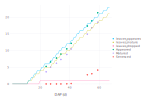

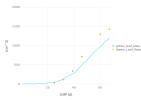

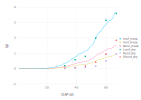

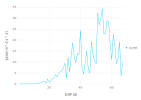

In [184]:
obs_drymass = CSV.read("$(@__DIR__)/../data/winter2021_DryMass.csv", DataFrame) |> unitfy
obs_area = CSV.read("$(@__DIR__)/../data/winter2021_Area.csv", DataFrame) |> unitfy
obs_leafnum = CSV.read("$(@__DIR__)/../data/winter2021_leafnum_consistent.csv", DataFrame) |> unitfy

r = simulate(Garlic.Model;
    config=Lettuce,
    stop="calendar.count",
    snap=s -> Dates.hour(s.calendar.time') == 12,
)
@test r.leaves_initiated[end] > 0

sln = visualize(r, :DAP, [:leaves_appeared, :leaves_mature, :leaves_dropped], kind=:line) # Fig. Leaf Number
visualize!(sln, obs_leafnum, :DAP, [:Appeared, :Matured, :Senesced]) |> display # Fig. Leaf Area
sa = visualize(r, :DAP, :green_leaf_area, kind=:line, ylim = (0,2000))
visualize!(sa, obs_area, :DAS, [:Green_Leaf_Area]) |> display # Fig. Leaf Area
sb = visualize(r, :DAP, [:leaf_mass, :root_mass, :stem_mass], kind=:line)
visualize!(sb, obs_drymass, :DAS, [:Leaf_dry, :Root_dry, :Shoot_dry]) |> display # Fig. Biomass
visualize(r, :DAP, [:A_net], kind=:line) |> display

In [195]:
evaluate(obs_leafnum, r; index = :DAP, target = :Appeared => :leaves_appeared, metric=:ef) |> display
evaluate(obs_leafnum, r; index = :DAP, target = :Appeared => :leaves_appeared, metric=:rmse) |> display
evaluate(obs_leafnum, r; index = :DAP, target = :Matured => :leaves_mature, metric=:ef) |> display
evaluate(obs_leafnum, r; index = :DAP, target = :Matured => :leaves_mature, metric=:rmse)

0.9608644206002425

0.9780835835645737

0.9581212342645069

0.9716387216171489